## 1 - Extraindo e tratando a base

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import lightgbm as lgb

from scipy import stats

from sklearn.feature_selection import chi2

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold

In [2]:
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')

shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')

item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')

test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [3]:


# Função que verifica valores nulos 

def missing_data(data):

    total = data.isnull().sum()

    percent = (data.isnull().sum()/data.isnull().count()*100)

    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    types = []

    for col in data.columns:

        dtype = str(data[col].dtype)

        types.append(dtype)

    tt['Types'] = types

    return(np.transpose(tt))

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:


# Garantir que a coluna 'date' seja convertida para datetime

sales_train['date'] = pd.to_datetime(sales_train['date'], format="%d.%m.%Y")



# Criar as novas colunas de ano, mês e mes_ano

sales_train['year'] = sales_train['date'].dt.year

sales_train['month'] = sales_train['date'].dt.month

sales_train['mes_ano'] = sales_train['date'].dt.strftime('%m-%Y')  # Formato de mês e ano



# Verificar se a coluna 'mes_ano' foi criada corretamente

print(sales_train[['date', 'year', 'month', 'mes_ano']].head())



# Agrupar por ano, mês, loja, item e calcular a soma das vendas

monthly_sales = sales_train.groupby(

    ["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month']

)['item_cnt_day'].sum().reset_index()



# Calcular o preço médio por item

monthly_sales_price = sales_train.groupby(

    ["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month']

)['item_price'].mean().reset_index()



# Renomear a coluna 'item_price' para 'item_price_mean' para indicar que é a média

monthly_sales_price = monthly_sales_price.rename(columns={"item_price": "item_price_mean"})



# Mesclar as duas tabelas: a de vendas mensais e a de preço médio

monthly_sales = pd.merge(monthly_sales, monthly_sales_price, on=["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month'], how='left')



# Calcular o faturamento mensal (item_price_mean * item_cnt_day)

monthly_sales['faturamento'] = monthly_sales['item_price_mean'] * monthly_sales['item_cnt_day']



# Agora calcular a média de faturamento por mês (por shop_id, item_id, etc.)

monthly_sales_avg_revenue = monthly_sales.groupby(

    ["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month']

)['faturamento'].mean().reset_index()



# Renomear a coluna para 'faturamento_medio_mensal'

monthly_sales_avg_revenue = monthly_sales_avg_revenue.rename(columns={"faturamento": "faturamento_medio_mensal"})



# Mesclar com o DataFrame original para adicionar a coluna 'faturamento_medio_mensal'

monthly_sales = pd.merge(monthly_sales, monthly_sales_avg_revenue, on=["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month'], how='left')



# Garantir que a coluna 'item_price' original seja incluída

monthly_sales = pd.merge(monthly_sales, sales_train[['shop_id', 'date_block_num', 'item_id', 'mes_ano', 'year', 'month', 'item_price']].drop_duplicates(), 

                         on=["shop_id", "date_block_num", "item_id", 'mes_ano', 'year', 'month'], how='left')



# Exibindo o resultado final

monthly_sales.head()








        date  year  month  mes_ano
0 2013-01-02  2013      1  01-2013
1 2013-01-03  2013      1  01-2013
2 2013-01-05  2013      1  01-2013
3 2013-01-06  2013      1  01-2013
4 2013-01-15  2013      1  01-2013


,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price
0,0,0,32,01-2013,2013,1,6.0,221.0,1326.0,1326.0,221.0
1,0,0,33,01-2013,2013,1,3.0,347.0,1041.0,1041.0,347.0
2,0,0,35,01-2013,2013,1,1.0,247.0,247.0,247.0,247.0
3,0,0,43,01-2013,2013,1,1.0,221.0,221.0,221.0,221.0
4,0,0,51,01-2013,2013,1,2.0,128.5,257.0,257.0,130.0


In [7]:


# Convertendo a coluna mes_ano para datetime

monthly_sales['mes_ano'] = pd.to_datetime(monthly_sales['mes_ano'], format='%m-%Y', errors='coerce')



# Criando uma variável de lag (mês anterior)

monthly_sales['prev_month_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_day'].shift(1)



# 2. Substituir valores nulos pela média de vendas do item

# Calcular a média de vendas do item (considerando todos os meses para o item)

item_mean_sales = monthly_sales.groupby('item_id')['item_cnt_day'].mean()



# Substituindo os valores nulos de 'prev_month_sales' pela média de vendas do item

monthly_sales['prev_month_sales'] = monthly_sales.apply(

    lambda row: item_mean_sales[row['item_id']] if pd.isna(row['prev_month_sales']) else row['prev_month_sales'],

    axis=1

)



# Exibindo as primeiras linhas após o tratamento

monthly_sales.head()

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,221.0,2.754342
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,347.0,1.492035
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,247.0,2.960000
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,221.0,1.000000
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,130.0,1.421965


In [8]:
# Aplicando função que aponta valores nulos.

missing_data(monthly_sales)

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales
Total,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,datetime64[ns],int32,int32,float64,float64,float64,float64,float64,float64


In [9]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [10]:
# Verifica quantidade distintas da shop_name

surface=len(shops["shop_name"].unique())

surface

60

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
missing_data(monthly_sales)

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales
Total,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,datetime64[ns],int32,int32,float64,float64,float64,float64,float64,float64


In [13]:
# Fazendo o join baseado na coluna 'id'

monthly_sales = pd.merge(monthly_sales, shops, on='shop_id', how='left')

missing_data(monthly_sales)

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,datetime64[ns],int32,int32,float64,float64,float64,float64,float64,float64,object


In [14]:
monthly_sales.head()

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,221.0,2.754342,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,347.0,1.492035,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,247.0,2.960000,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,221.0,1.000000,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,130.0,1.421965,"!Якутск Орджоникидзе, 56 фран"


## 2 - Análise exploaratória

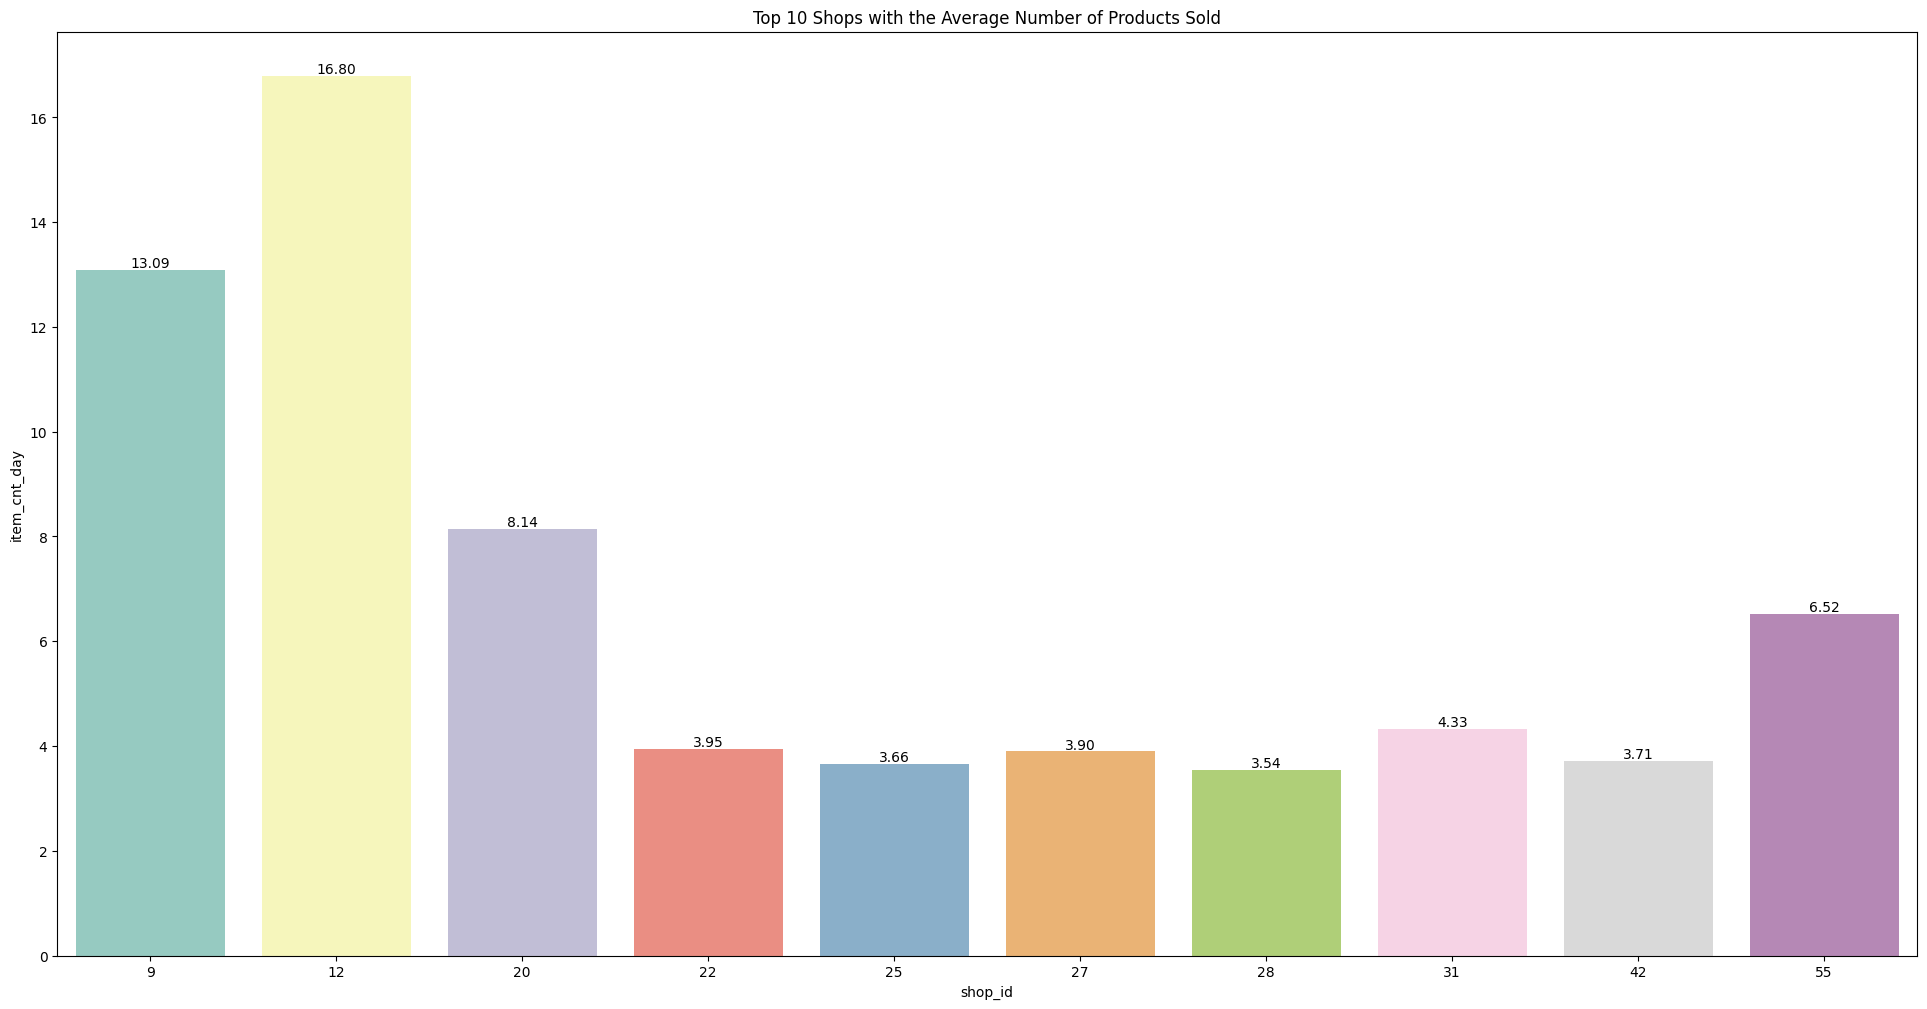

In [15]:
# Agrupar por shop_name e calcular a média de itens vendidos (item_cnt_day)

avg_sales_per_shop = monthly_sales.groupby('shop_id')['item_cnt_day'].mean().reset_index()



# Ordenar as lojas pela média de itens vendidos de forma decrescente

top_10_shops = avg_sales_per_shop.sort_values(by='item_cnt_day', ascending=False).head(10)



# Tamanho da figura

f, ax = plt.subplots(1, 1, figsize=(24, 12))



# Plot do gráfico de barras para as top 10 lojas

g = sns.barplot(x='shop_id', y='item_cnt_day', data=top_10_shops, palette='Set3')



# Título do gráfico

g.set_title("Top 10 Shops with the Average Number of Products Sold")



# Adicionando os números acima de cada barra

for p in ax.patches:

    height = p.get_height()  # Altura da barra

    label = '{:1.2f}'.format(height)  # Texto com a média

    ax.text(p.get_x() + p.get_width() / 2., height + 0.05, label, ha="center")  # Posiciona o texto



# Exibe o gráfico

plt.show()




In [16]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [17]:
missing_data(items)

,item_name,item_id,item_category_id
Total,0,0,0
Percent,0.0,0.0,0.0
Types,object,int64,int64


In [18]:
# Fazendo o join baseado na coluna 'id'

monthly_sales = pd.merge(monthly_sales, items, on='item_id', how='left')

missing_data(monthly_sales)

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name,item_name,item_category_id
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,datetime64[ns],int32,int32,float64,float64,float64,float64,float64,float64,object,object,int64


In [19]:
monthly_sales.head()

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name,item_name,item_category_id
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,221.0,2.754342,"!Якутск Орджоникидзе, 56 фран",1+1,40
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,347.0,1.492035,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,247.0,2.960000,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,221.0,1.000000,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,130.0,1.421965,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57


Index(['item_id', 'item_cnt_day', 'item_name'], dtype='object')


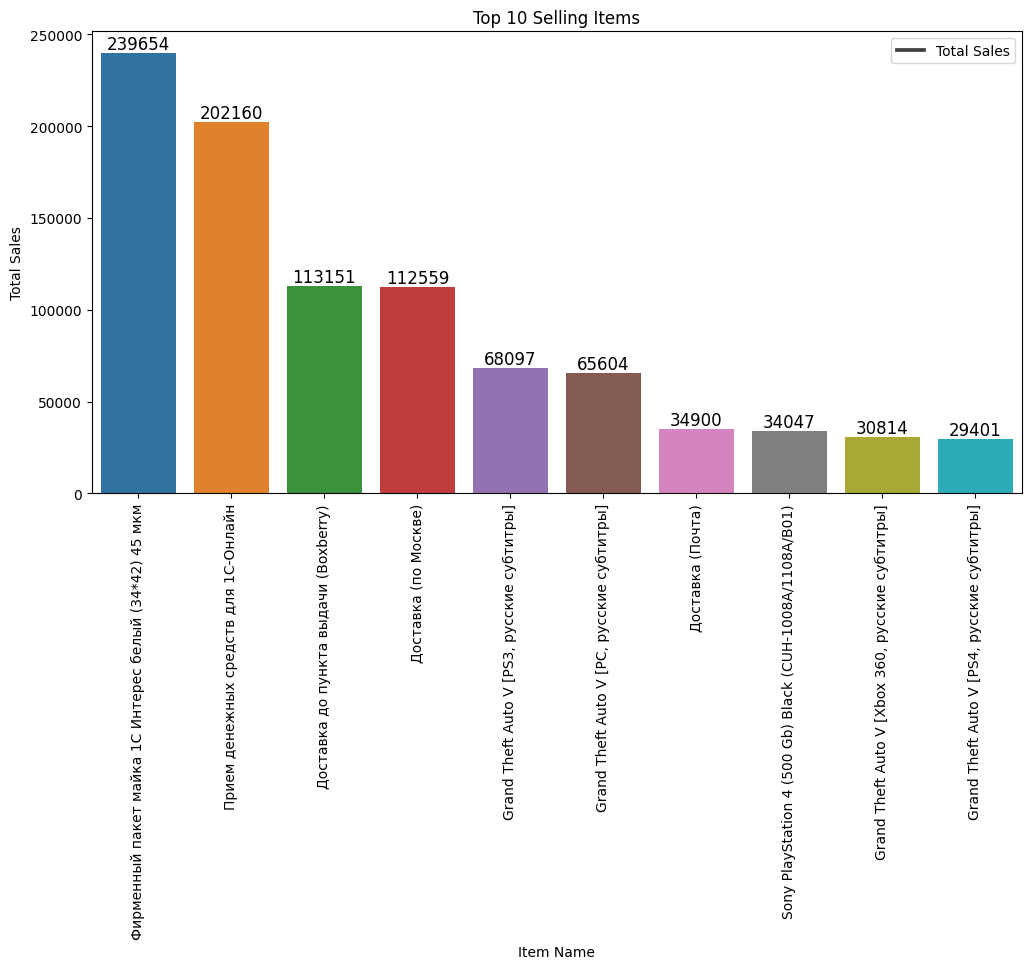

In [20]:
top_items = monthly_sales.groupby('item_id').agg({'item_cnt_day': 'sum'}).sort_values(by='item_cnt_day', ascending=False).head(10)

top_items = top_items.merge(items[['item_id', 'item_name']], on='item_id')



# Verificar as colunas após o merge

print(top_items.columns)



plt.figure(figsize=(12, 6))

sns.barplot(x='item_name', y='item_cnt_day', data=top_items)



# Adicionando os valores numéricos acima das barras

for p in plt.gca().patches:

    height = p.get_height()  # Altura da barra

    label = '{:1.0f}'.format(height)  # Formatação do número

    plt.text(p.get_x() + p.get_width() / 2., height + 0.05, label, ha="center", va="bottom", fontsize=12)



# Adicionando a legenda

plt.legend(['Total Sales'], loc='upper right')



# Rotacionando os nomes dos itens

plt.xticks(rotation=90)



# Título e rótulos dos eixos

plt.title('Top 10 Selling Items')

plt.xlabel('Item Name')

plt.ylabel('Total Sales')



# Exibindo o gráfico

plt.show()






In [21]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [22]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [23]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [24]:
missing_data(item_categories)

,item_category_name,item_category_id
Total,0,0
Percent,0.0,0.0
Types,object,int64


In [25]:
monthly_sales = pd.merge(monthly_sales, item_categories, on='item_category_id', how='left')

missing_data(monthly_sales)

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name,item_name,item_category_id,item_category_name
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,datetime64[ns],int32,int32,float64,float64,float64,float64,float64,float64,object,object,int64,object


In [26]:
monthly_sales.head()

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name,item_name,item_category_id,item_category_name
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,221.0,2.754342,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,347.0,1.492035,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,247.0,2.960000,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,221.0,1.000000,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,130.0,1.421965,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


   item_category_id  item_cnt_day                   item_category_name
0                30      727323.0        Игры PC - Стандартные издания
1                40      691688.0                           Кино - DVD
2                19      444648.0                           Игры - PS3
3                55      353056.0  Музыка - CD локального производства
4                28      327883.0     Игры PC - Дополнительные издания


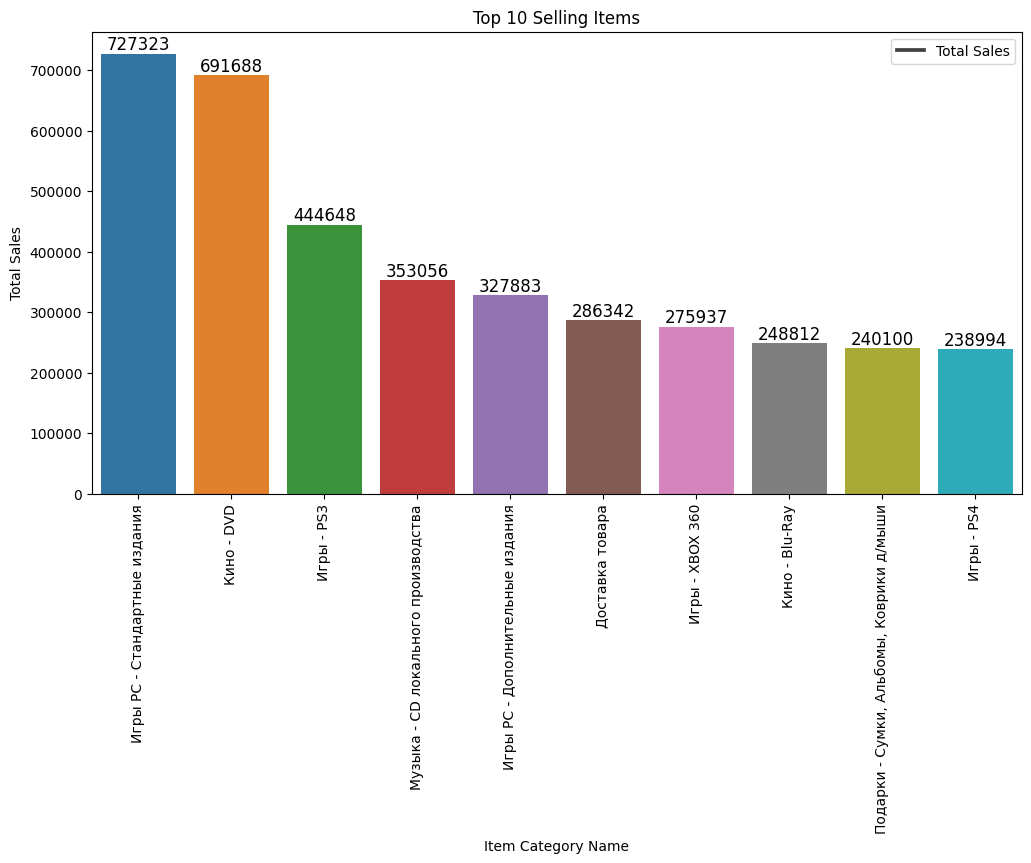

In [27]:
# Agrupando as vendas por 'item_id' e somando as quantidades vendidas

top_items = monthly_sales.groupby('item_category_id').agg({'item_cnt_day': 'sum'}).sort_values(by='item_cnt_day', ascending=False).head(10)



# Fazendo o merge com a tabela de items, para pegar o nome da categoria do item (ou o nome do item, se disponível)

# Se você quiser usar a 'item_category_name' como rótulo, ajuste aqui

top_items = top_items.merge(item_categories[['item_category_id', 'item_category_name']], on='item_category_id')



# Exibindo as primeiras linhas para verificar a estrutura dos dados

print(top_items.head())



# Gerando o gráfico

plt.figure(figsize=(12, 6))

sns.barplot(x='item_category_name', y='item_cnt_day', data=top_items)



# Adicionando os valores numéricos acima das barras

for p in plt.gca().patches:

    height = p.get_height()  # Altura da barra

    label = '{:1.0f}'.format(height)  # Texto com número

    plt.text(p.get_x() + p.get_width() / 2., height + 0.05, label, ha="center", va="bottom", fontsize=12)



# Adicionando a legenda (pode ser opcional, depende da sua necessidade)

plt.legend(['Total Sales'], loc='upper right')



# Rotacionando os nomes dos itens (ou categorias)

plt.xticks(rotation=90)



# Título e rótulos dos eixos

plt.title('Top 10 Selling Items')

plt.xlabel('Item Category Name')  # Ou 'Item Name', se você encontrar essa coluna

plt.ylabel('Total Sales')



# Exibindo o gráfico

plt.show()


## 3 - Seleção e tratamento de Variaveis (feature selection)

#### Algumas transformações são baseadas no trabalho: https://www.kaggle.com/code/dimitreoliveira/model-stacking-feature-engineering-and-eda

In [28]:
# Verificar se existem valores negativos nas colunas especificadas

columns_to_check = ['item_cnt_day', 'item_price_mean', 'faturamento', 'faturamento_medio_mensal', 'item_price', 'prev_month_sales']



# Verificar para cada coluna

negative_values = monthly_sales[columns_to_check].lt(0).sum()



# Exibir as colunas que têm valores negativos

print("Valores negativos por coluna:")

print(negative_values)


Valores negativos por coluna:
item_cnt_day                925
item_price_mean               0
faturamento                 925
faturamento_medio_mensal    925
item_price                    1
prev_month_sales            545
dtype: int64


In [29]:
# Verificar se existem valores negativos nas colunas especificadas

columns_to_check = ['item_cnt_day', 'item_price_mean', 'faturamento', 'faturamento_medio_mensal', 'item_price', 'prev_month_sales']



# Filtrar as linhas que não possuem valores negativos nas colunas especificadas

monthly_sales = monthly_sales[monthly_sales[columns_to_check].ge(0).all(axis=1)]



# Verificar se o filtro foi aplicado corretamente

print("Número de linhas após excluir valores negativos:", len(monthly_sales))

Número de linhas após excluir valores negativos: 1737576


In [30]:
gp_item_price = monthly_sales.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})

gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']



monthly_sales = pd.merge(monthly_sales, gp_item_price, on='item_id', how='left')

monthly_sales.head()


/tmp/ipykernel_17/170883269.py:1: FutureWarning: The provided callable <function min at 0x7b280ce5d480> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gp_item_price = monthly_sales.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
/tmp/ipykernel_17/170883269.py:1: FutureWarning: The provided callable <function max at 0x7b280ce5d360> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gp_item_price = monthly_sales.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})


,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,item_price,prev_month_sales,shop_name,item_name,item_category_id,item_category_name,hist_min_item_price,hist_max_item_price
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,221.0,2.754342,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD,70.62,349.0
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,347.0,1.492035,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray,128.20,499.0
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,247.0,2.960000,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD,148.00,399.0
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,221.0,1.000000,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,98.00,248.0
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,130.0,1.421965,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,101.50,299.0


In [31]:
# Funções para cálculo das estatísticas
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

# Lista das funções e seus respectivos nomes
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

# Ajustando o código para evitar o erro de incompatibilidade de índices
for i in range(len(function_list)):
    # Agrupar os dados e aplicar as funções
    result = monthly_sales.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt_day'].apply(function_list[i])
    
    # Alinhar o índice do resultado com o índice original do DataFrame
    result = result.reset_index(level=['shop_id', 'item_category_id', 'item_id'], drop=True)
    
    # Adicionar a nova coluna ao DataFrame
    monthly_sales[('item_cnt_%s' % function_name[i])] = result

# Preenchendo os valores ausentes para o "item_cnt_std" com 0
monthly_sales['item_cnt_std'].fillna(0, inplace=True)

# Exibir as primeiras linhas do DataFrame resultante
monthly_sales.head()



/tmp/ipykernel_17/1193283575.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_sales['item_cnt_std'].fillna(0, inplace=True)


,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,...,shop_name,item_name,item_category_id,item_category_name,hist_min_item_price,hist_max_item_price,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,0,32,2013-01-01,2013,1,6.0,221.0,1326.0,1326.0,...,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD,70.62,349.0,6.0,6.0,6.0,0.0
1,0,0,33,2013-01-01,2013,1,3.0,347.0,1041.0,1041.0,...,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray,128.20,499.0,3.0,3.0,3.0,0.0
2,0,0,35,2013-01-01,2013,1,1.0,247.0,247.0,247.0,...,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD,148.00,399.0,1.0,1.0,1.0,0.0
3,0,0,43,2013-01-01,2013,1,1.0,221.0,221.0,221.0,...,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,98.00,248.0,1.0,1.0,1.0,0.0
4,0,0,51,2013-01-01,2013,1,2.0,128.5,257.0,257.0,...,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,101.50,299.0,2.0,2.0,2.0,0.0


In [32]:
monthly_sales.head().T

,0,1,2,3,4
shop_id,0,0,0,0,0
date_block_num,0,0,0,0,0
item_id,32,33,35,43,51
mes_ano,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
year,2013,2013,2013,2013,2013
month,1,1,1,1,1
item_cnt_day,6.0,3.0,1.0,1.0,2.0
item_price_mean,221.0,347.0,247.0,221.0,128.5
faturamento,1326.0,1041.0,247.0,221.0,257.0
faturamento_medio_mensal,1326.0,1041.0,247.0,221.0,257.0


In [33]:
missing_data(item_categories)

,item_category_name,item_category_id
Total,0,0
Percent,0.0,0.0
Types,object,int64


In [34]:
# Selecionar colunas numéricas

numeric_columns = monthly_sales.select_dtypes(include=['number']).columns



# Verificar se existem valores negativos nas colunas numéricas

negative_values = monthly_sales[numeric_columns].lt(0).sum()



# Verificar se existem valores infinitos nas colunas numéricas

infinite_values = monthly_sales[numeric_columns].isin([np.inf, -np.inf]).sum()



# Exibir as colunas com valores negativos

print("Valores negativos por coluna (em colunas numéricas):")

print(negative_values)



# Exibir as colunas com valores infinitos

print("Valores infinitos por coluna (em colunas numéricas):")

print(infinite_values)


Valores negativos por coluna (em colunas numéricas):
shop_id                     0
date_block_num              0
item_id                     0
year                        0
month                       0
item_cnt_day                0
item_price_mean             0
faturamento                 0
faturamento_medio_mensal    0
item_price                  0
prev_month_sales            0
item_category_id            0
hist_min_item_price         0
hist_max_item_price         0
item_cnt_min                0
item_cnt_max                0
item_cnt_mean               0
item_cnt_std                0
dtype: int64
Valores infinitos por coluna (em colunas numéricas):
shop_id                     0
date_block_num              0
item_id                     0
year                        0
month                       0
item_cnt_day                0
item_price_mean             0
faturamento                 0
faturamento_medio_mensal    0
item_price                  0
prev_month_sales            0
item_catego

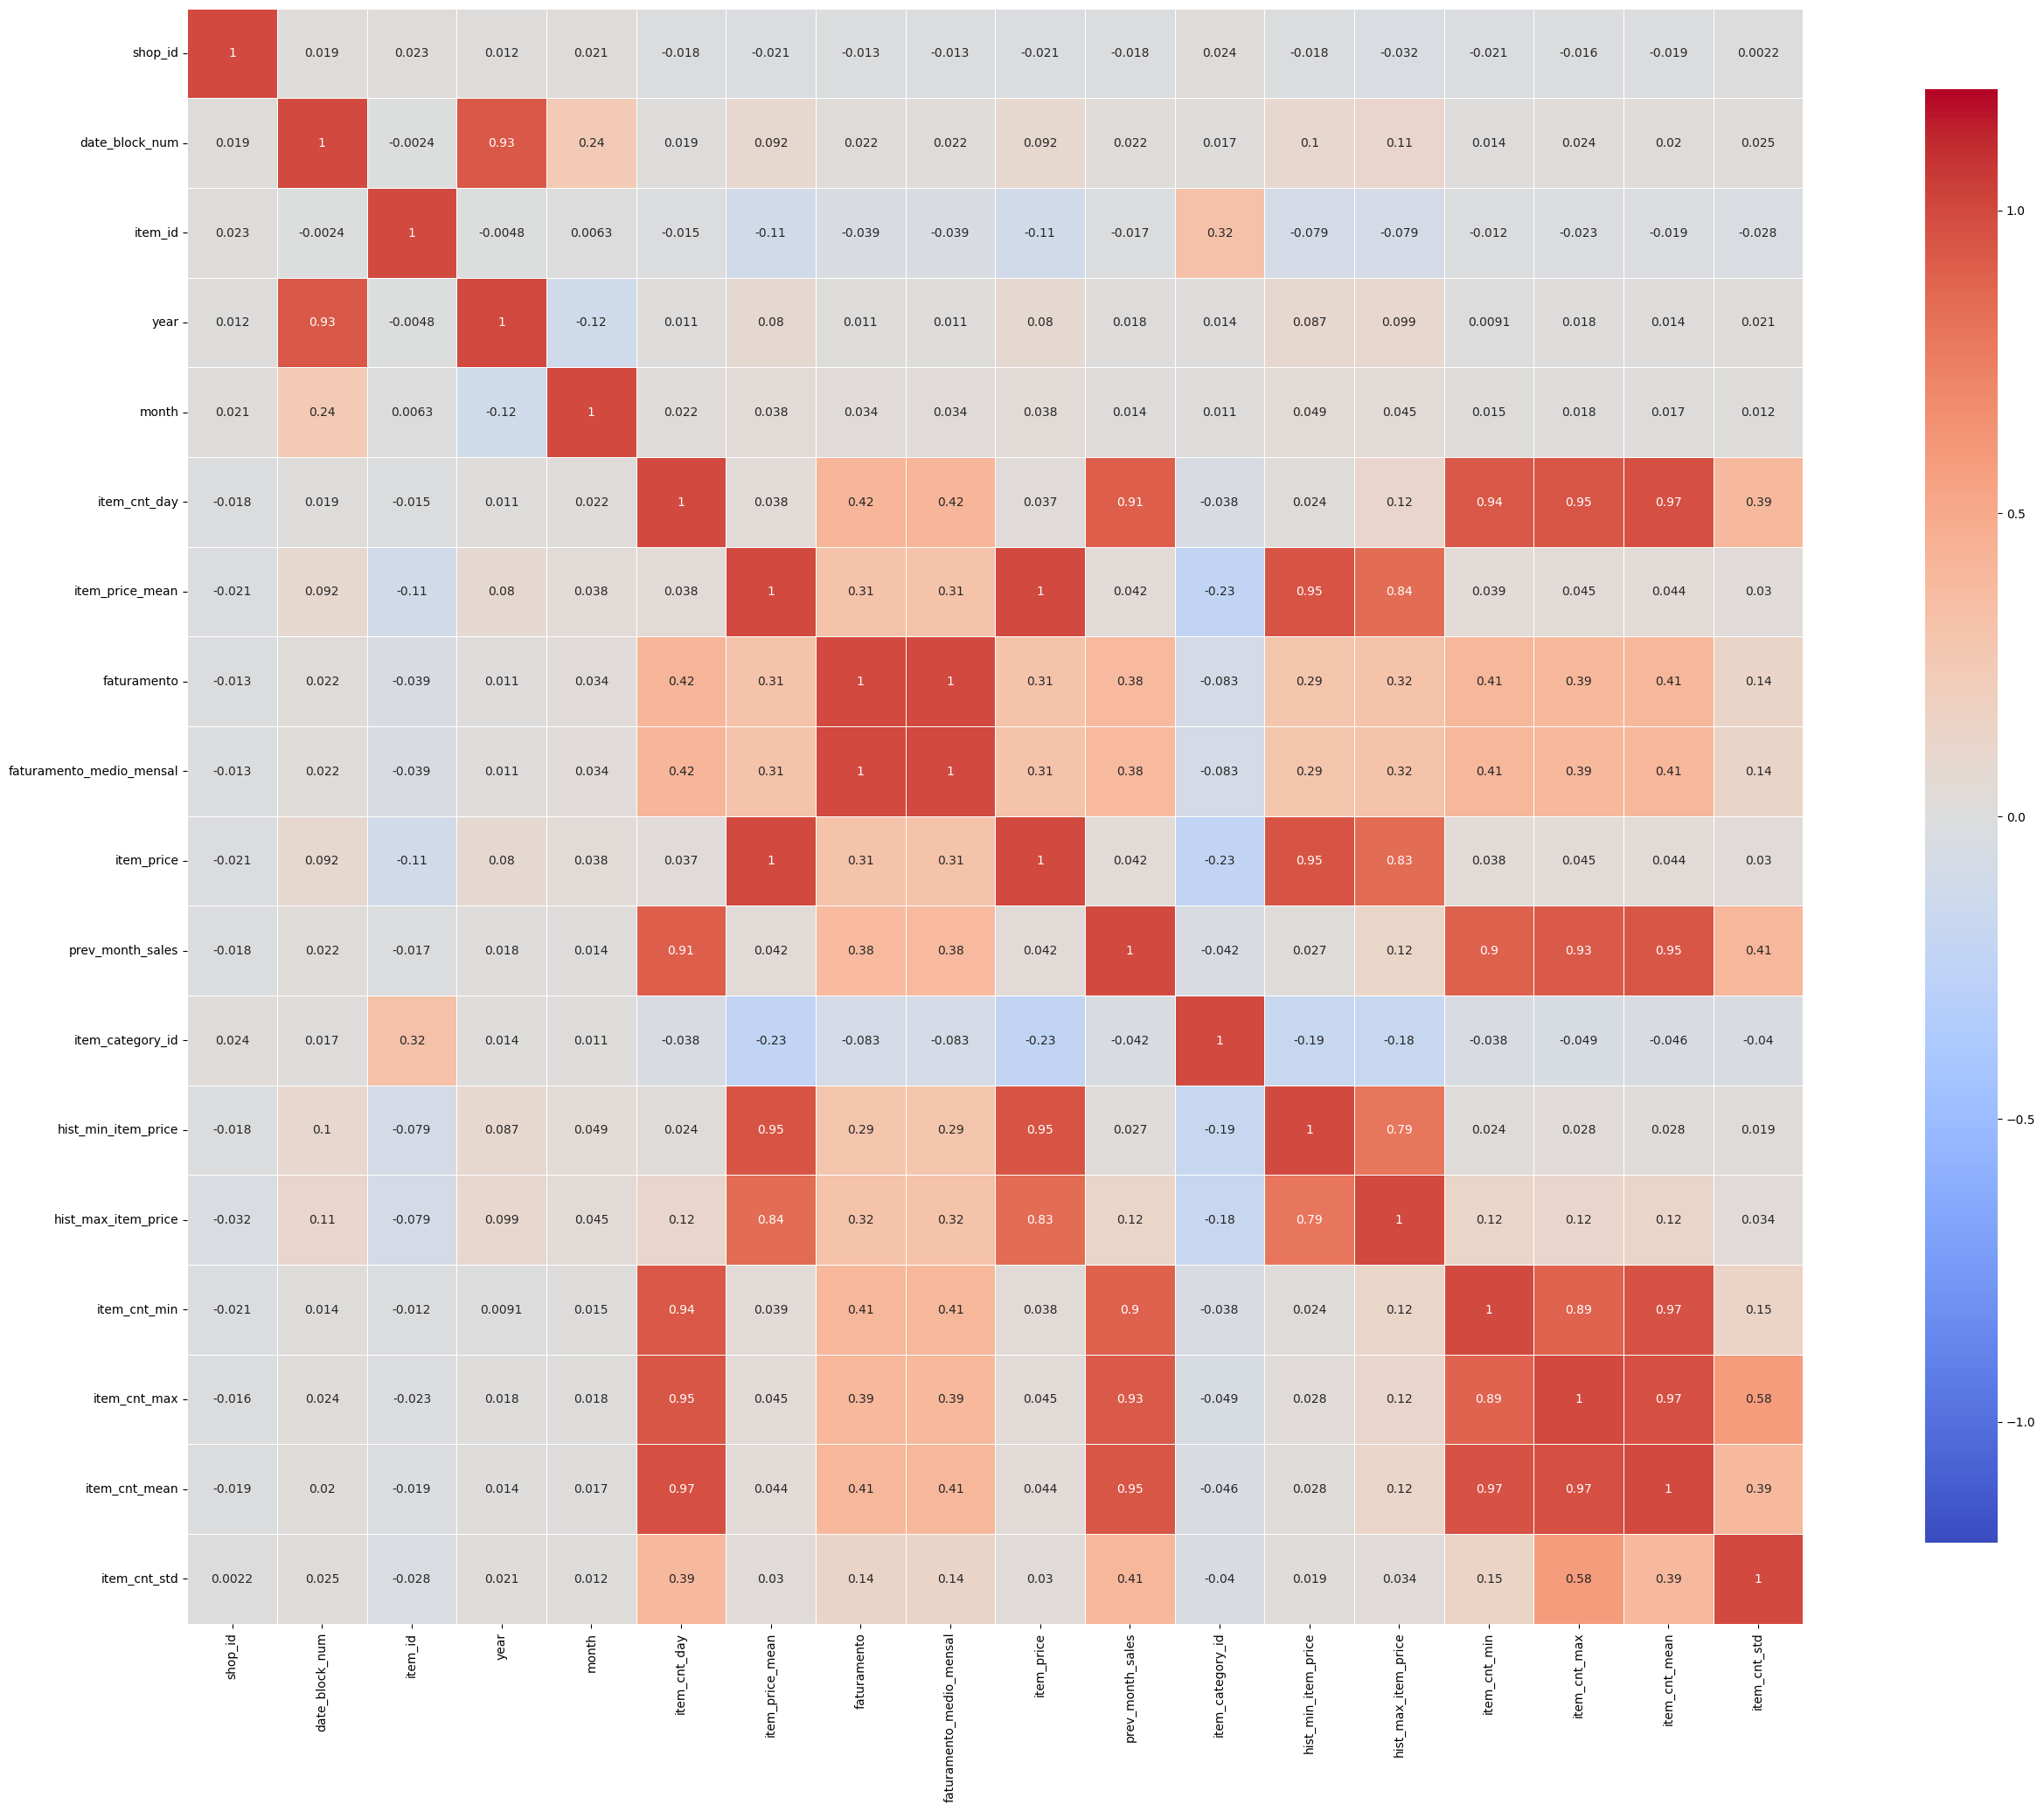

In [35]:
# Blind Approach on all Numerical attributes

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']



newDf = monthly_sales.select_dtypes(include = numerics)

corr_matrix = newDf.corr()



# mask = np.zeros_like(corr_matrix, dtype = np.bool)

# mask[np.triu_indices_from(mask)] = True



f, ax = plt.subplots(figsize = (36,24))

sns.heatmap(corr_matrix, center=0,

            square=True, linewidth = .5,

            cbar_kws = {"shrink": .9}, vmin = -1.2,

            vmax=1.2, cmap = "coolwarm", annot = True)



plt.show()

In [36]:




# Método 1: Usando o IQR para detectar outliers nas 3 colunas

def detect_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)

    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    

    limite_inferior = Q1 - 1.5 * IQR

    limite_superior = Q3 + 1.5 * IQR

    

    # Identificar outliers

    outliers = df[(df[column] < limite_inferior) | (df[column] > limite_superior)]

    return outliers



# Método 2: Usando o Z-Score para detectar outliers

def detect_outliers_zscore(df, column):

    z_scores = stats.zscore(df[column].dropna())  # Remove NaN antes de calcular o Z-Score

    outliers = df[np.abs(z_scores) > 3]

    return outliers



# Identificar outliers para as 3 colunas: item_price_mean, item_cnt_day, faturamento_medio_mensal



# IQR para item_price_mean

outliers_iqr_item_price = detect_outliers_iqr(monthly_sales, 'item_price_mean')

print("Outliers para item_price_mean identificados pelo IQR:")

print(outliers_iqr_item_price)



# IQR para item_cnt_day

outliers_iqr_item_cnt_day = detect_outliers_iqr(monthly_sales, 'item_cnt_day')

print("\nOutliers para item_cnt_day identificados pelo IQR:")

print(outliers_iqr_item_cnt_day)



# IQR para faturamento_medio_mensal

outliers_iqr_faturamento = detect_outliers_iqr(monthly_sales, 'faturamento_medio_mensal')

print("\nOutliers para faturamento_medio_mensal identificados pelo IQR:")

print(outliers_iqr_faturamento)



# IQR para prev_month_sales

outliers_iqr_prev_month_sales = detect_outliers_iqr(monthly_sales, 'prev_month_sales')

print("\nOutliers para faturamento_medio_mensal identificados pelo IQR:")

print(outliers_iqr_prev_month_sales)



# Z-Score para item_price_mean

outliers_zscore_item_price = detect_outliers_zscore(monthly_sales, 'item_price_mean')

print("\nOutliers para item_price_mean identificados pelo Z-Score:")

print(outliers_zscore_item_price)



# Z-Score para item_cnt_day

outliers_zscore_item_cnt_day = detect_outliers_zscore(monthly_sales, 'item_cnt_day')

print("\nOutliers para item_cnt_day identificados pelo Z-Score:")

print(outliers_zscore_item_cnt_day)



# Z-Score para faturamento_medio_mensal

outliers_zscore_faturamento = detect_outliers_zscore(monthly_sales, 'faturamento_medio_mensal')

print("\nOutliers para faturamento_medio_mensal identificados pelo Z-Score:")

print(outliers_zscore_faturamento)



# Z-Score para prev_month_sales

outliers_zscore_rev_month_sales = detect_outliers_zscore(monthly_sales, 'prev_month_sales')

print("\nOutliers para faturamento_medio_mensal identificados pelo Z-Score:")

print(outliers_zscore_rev_month_sales)




Outliers para item_price_mean identificados pelo IQR:
         shop_id  date_block_num  item_id    mes_ano  year  month  \
100            0               0     1471 2013-01-01  2013      1   
101            0               0     1472 2013-01-01  2013      1   
107            0               0     1524 2013-01-01  2013      1   
109            0               0     1592 2013-01-01  2013      1   
110            0               0     1595 2013-01-01  2013      1   
...          ...             ...      ...        ...   ...    ...   
1737487       59              33    16825 2015-10-01  2015     10   
1737505       59              33    17660 2015-10-01  2015     10   
1737552       59              33    20392 2015-10-01  2015     10   
1737555       59              33    20629 2015-10-01  2015     10   
1737560       59              33    21361 2015-10-01  2015     10   

         item_cnt_day  item_price_mean  faturamento  faturamento_medio_mensal  \
100               8.0           2127

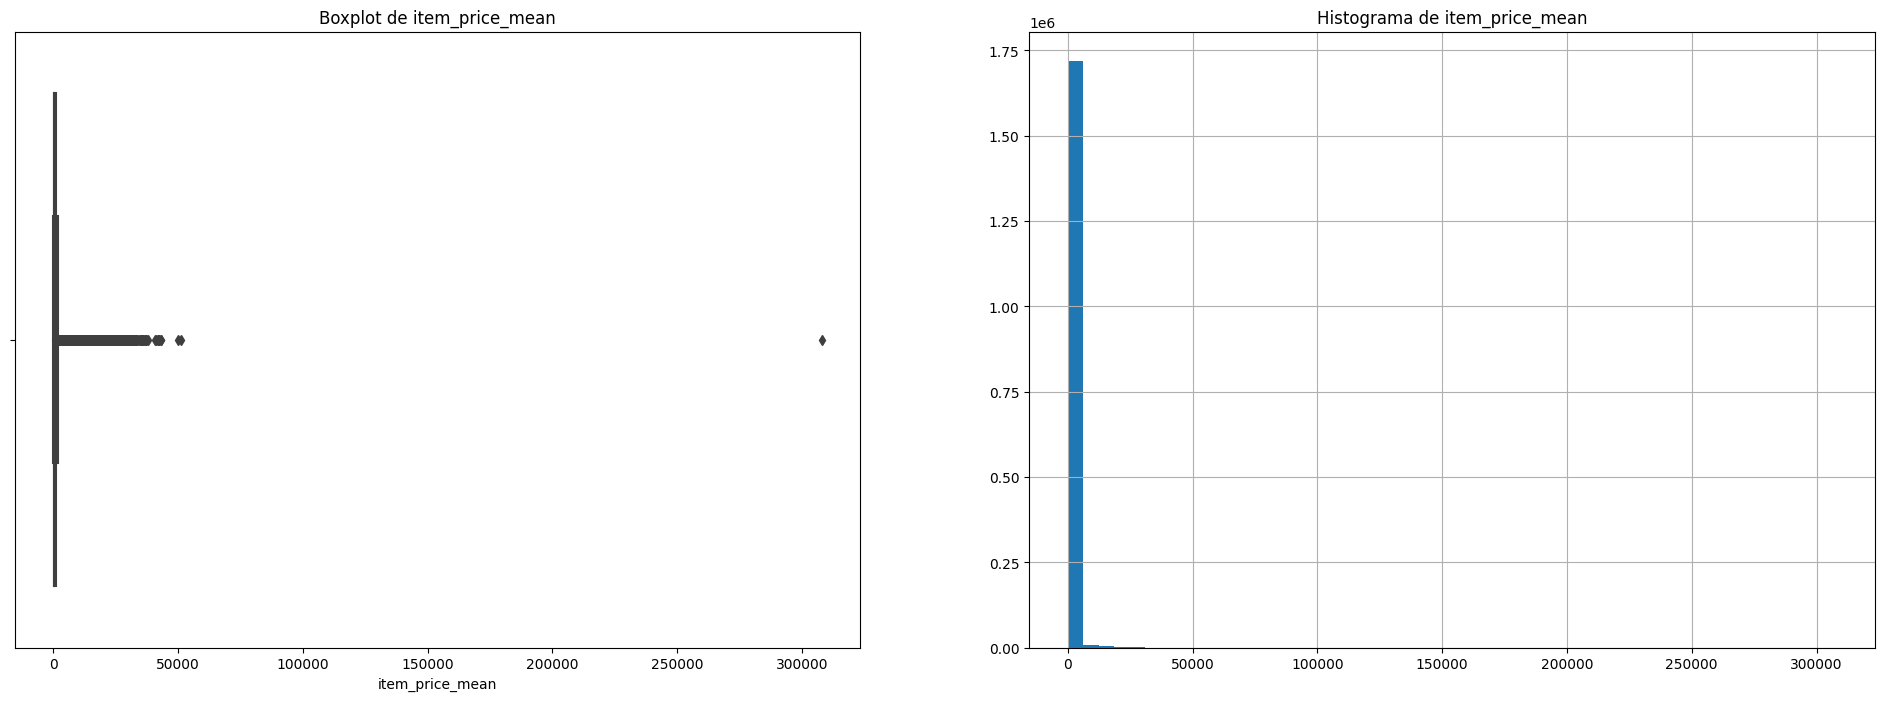

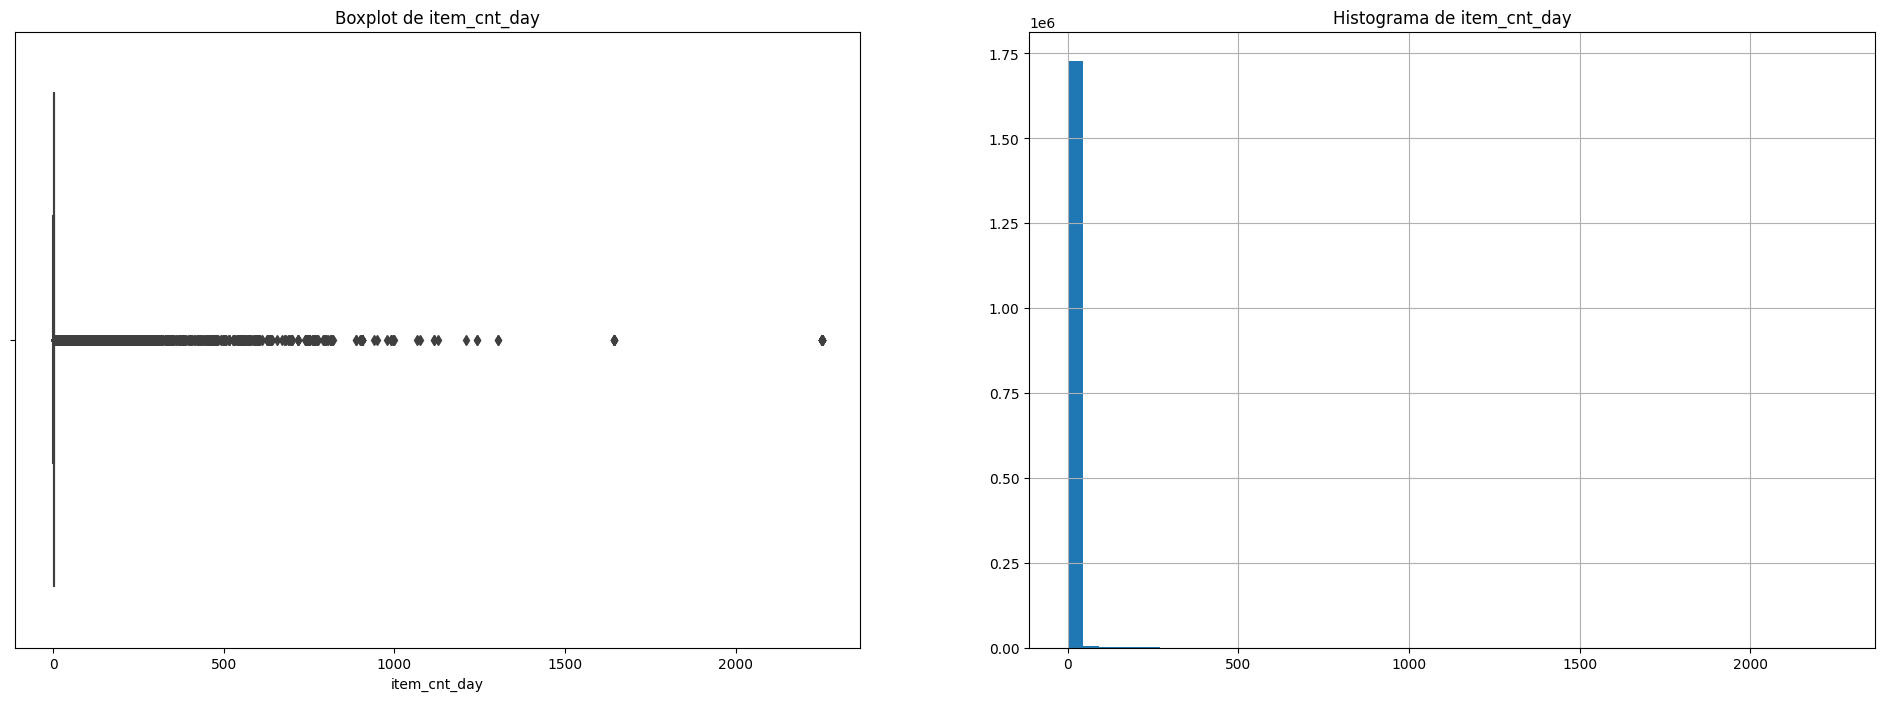

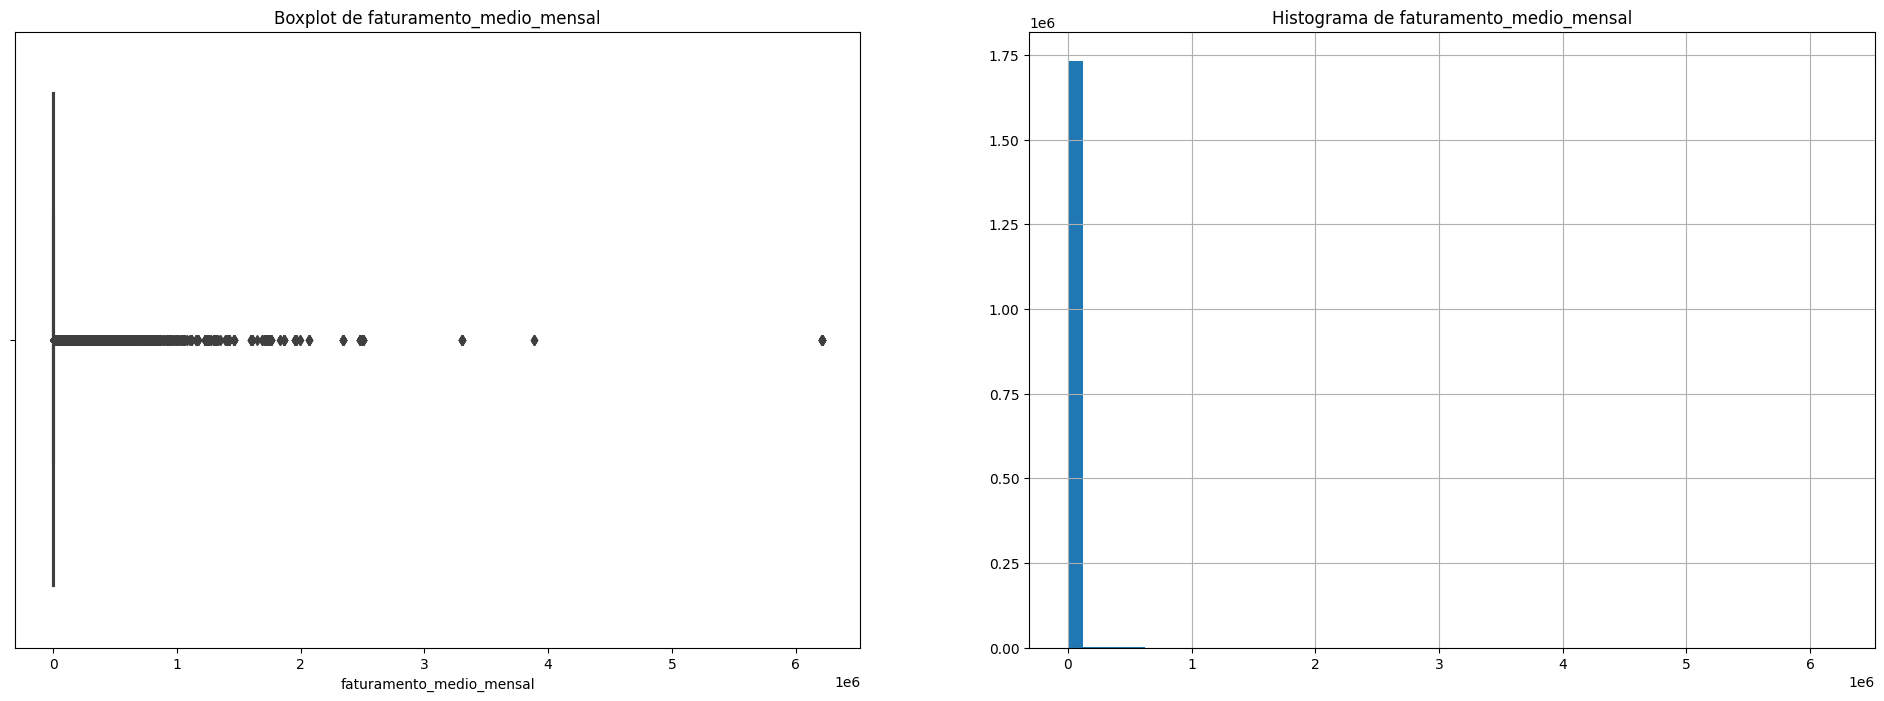

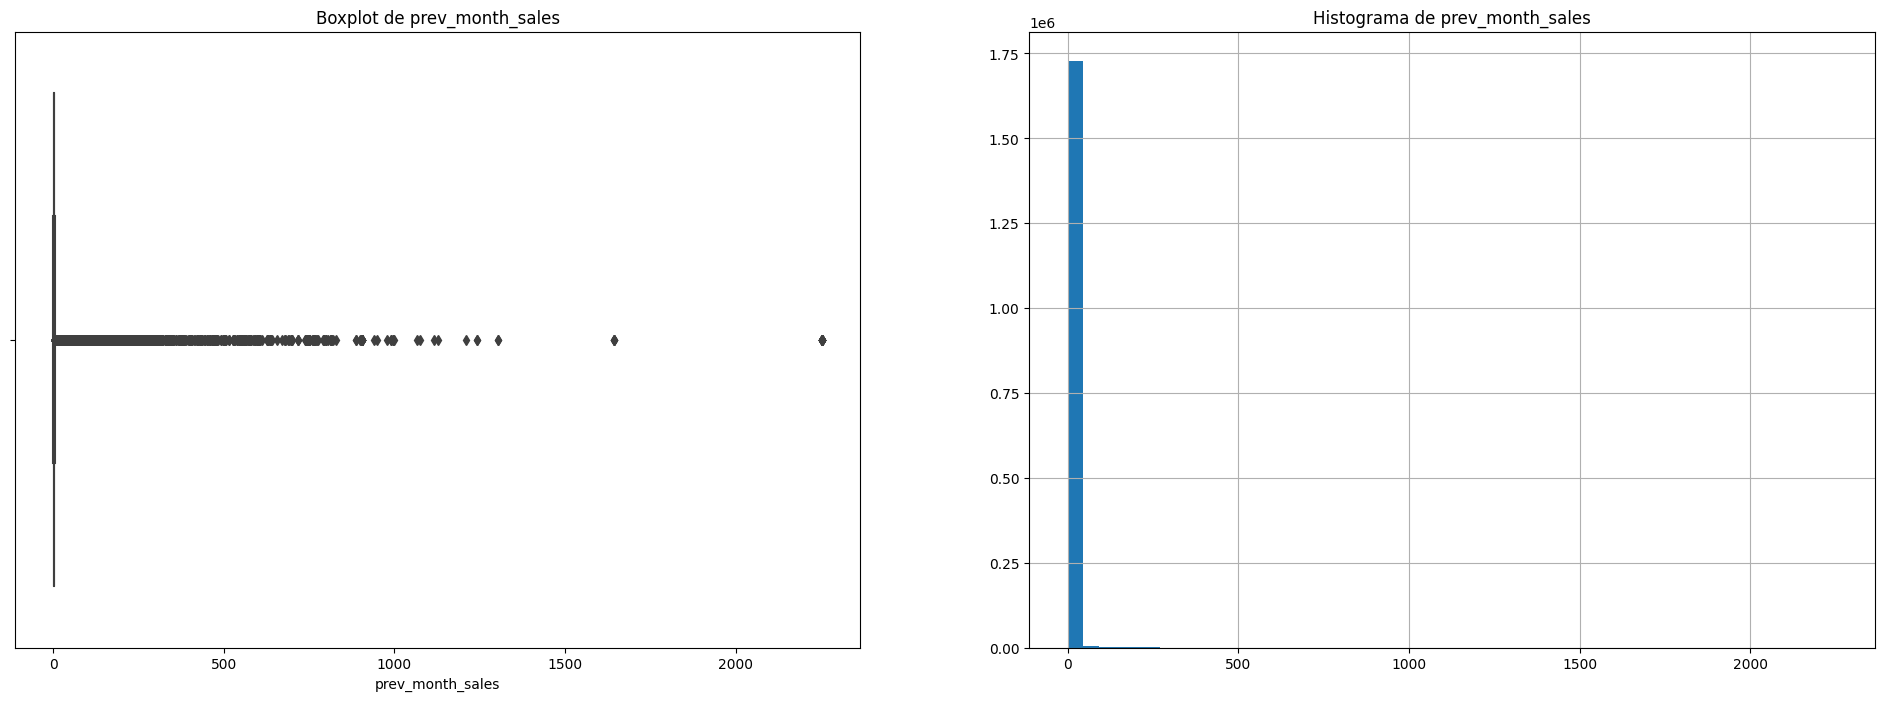

In [37]:
# Boxplot e histograma para 'item_price_mean'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['item_price_mean'])

plt.title('Boxplot de item_price_mean')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['item_price_mean'].hist(bins=50)

plt.title('Histograma de item_price_mean')



plt.show()



# Boxplot e histograma para 'item_cnt_day'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['item_cnt_day'])

plt.title('Boxplot de item_cnt_day')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['item_cnt_day'].hist(bins=50)

plt.title('Histograma de item_cnt_day')



plt.show()



# Boxplot e histograma para 'faturamento_medio_mensal'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['faturamento_medio_mensal'])

plt.title('Boxplot de faturamento_medio_mensal')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['faturamento_medio_mensal'].hist(bins=50)

plt.title('Histograma de faturamento_medio_mensal')



plt.show()





# Boxplot e histograma para 'prev_month_sales'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['prev_month_sales'])

plt.title('Boxplot de prev_month_sales')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['prev_month_sales'].hist(bins=50)

plt.title('Histograma de prev_month_sales')



plt.show()


In [38]:
# Substituir valores negativos por NaN

monthly_sales['item_price_mean'] = monthly_sales['item_price_mean'].apply(lambda x: x if x > 0 else np.nan)



# Aplicar a transformação logarítmica apenas nos valores positivos

monthly_sales['item_price_mean'] = np.log(monthly_sales['item_price_mean'] + 1)





# Substituir valores negativos por NaN

monthly_sales['item_cnt_day'] = monthly_sales['item_cnt_day'].apply(lambda x: x if x > 0 else np.nan)



# Aplicar a transformação logarítmica apenas nos valores positivos

monthly_sales['item_cnt_day'] = np.log(monthly_sales['item_cnt_day'] + 1)





# Substituir valores negativos por NaN

monthly_sales['faturamento_medio_mensal'] = monthly_sales['faturamento_medio_mensal'].apply(lambda x: x if x > 0 else np.nan)



# Aplicar a transformação logarítmica apenas nos valores positivos

monthly_sales['faturamento_medio_mensal'] = np.log(monthly_sales['faturamento_medio_mensal'] + 1)





# Substituir valores negativos por NaN

monthly_sales['prev_month_sales'] = monthly_sales['prev_month_sales'].apply(lambda x: x if x > 0 else np.nan)



# Aplicar a transformação logarítmica apenas nos valores positivos

monthly_sales['prev_month_sales'] = np.log(monthly_sales['prev_month_sales'] + 1)


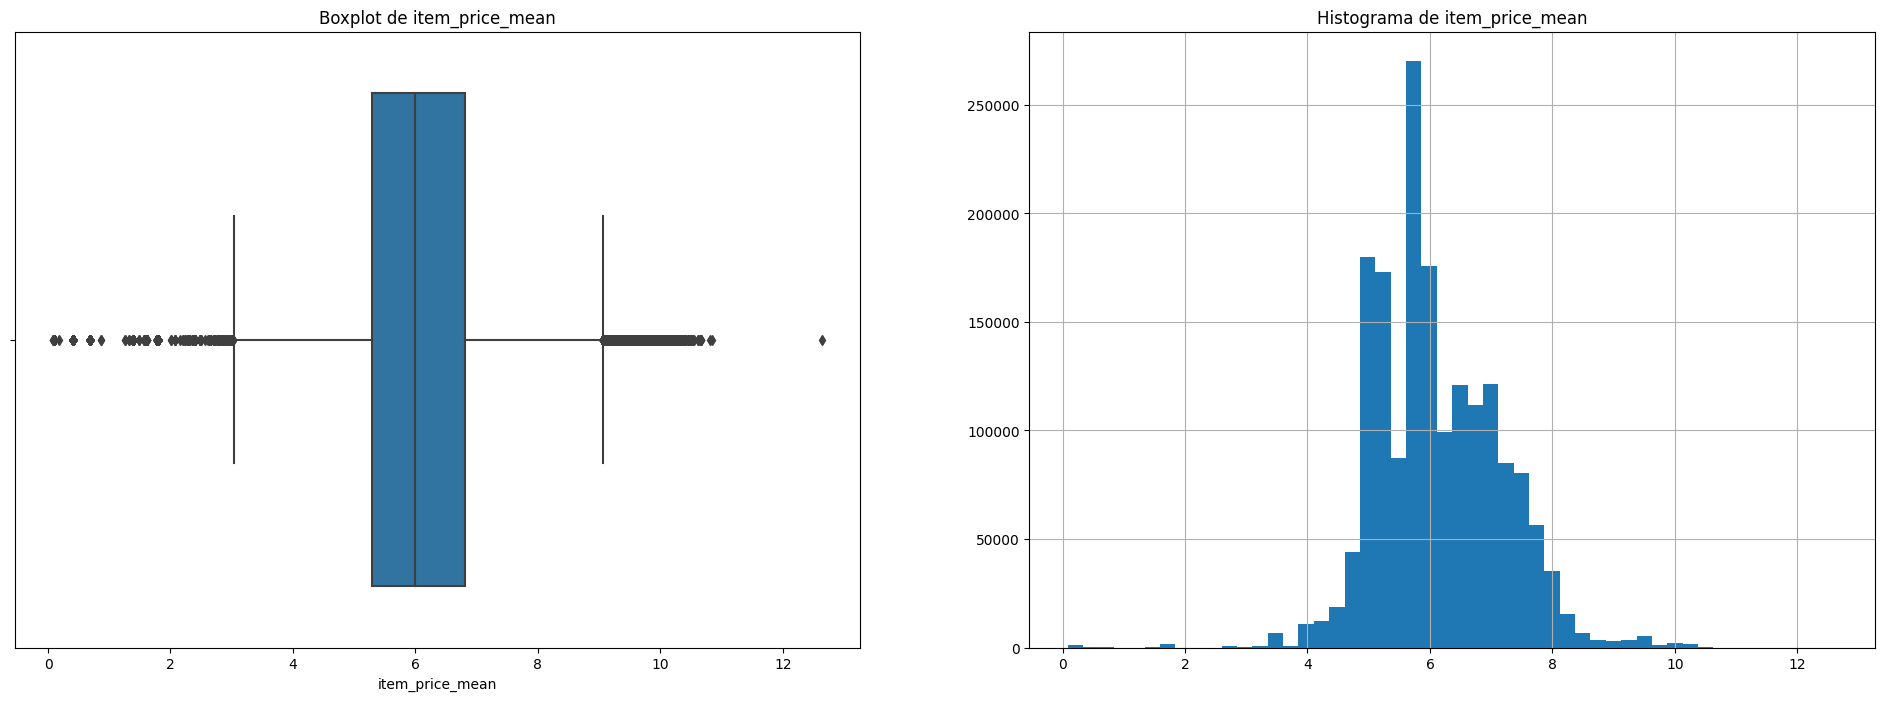

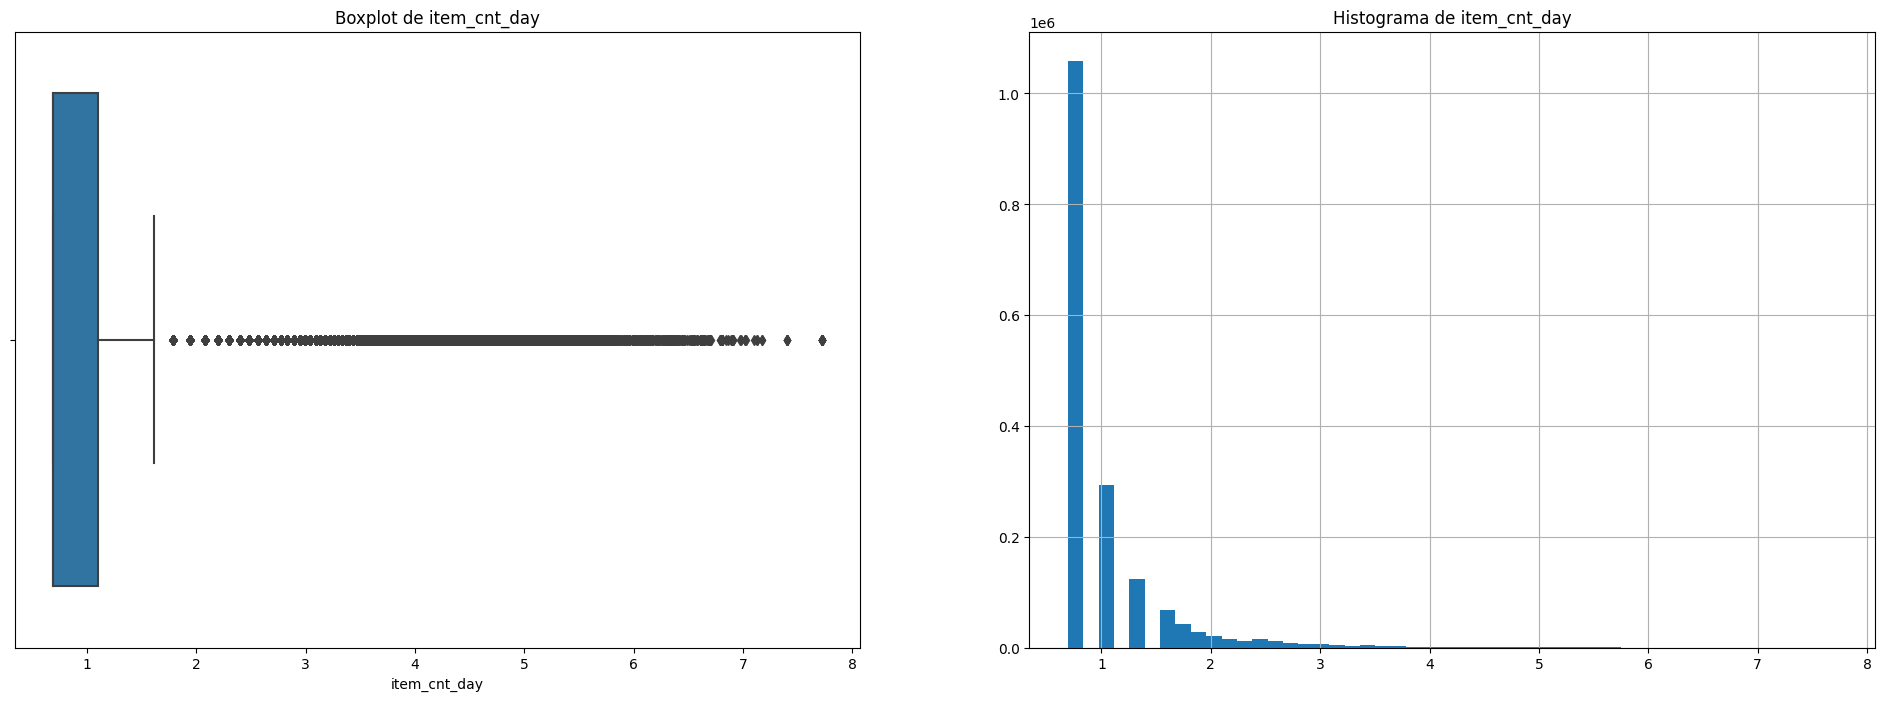

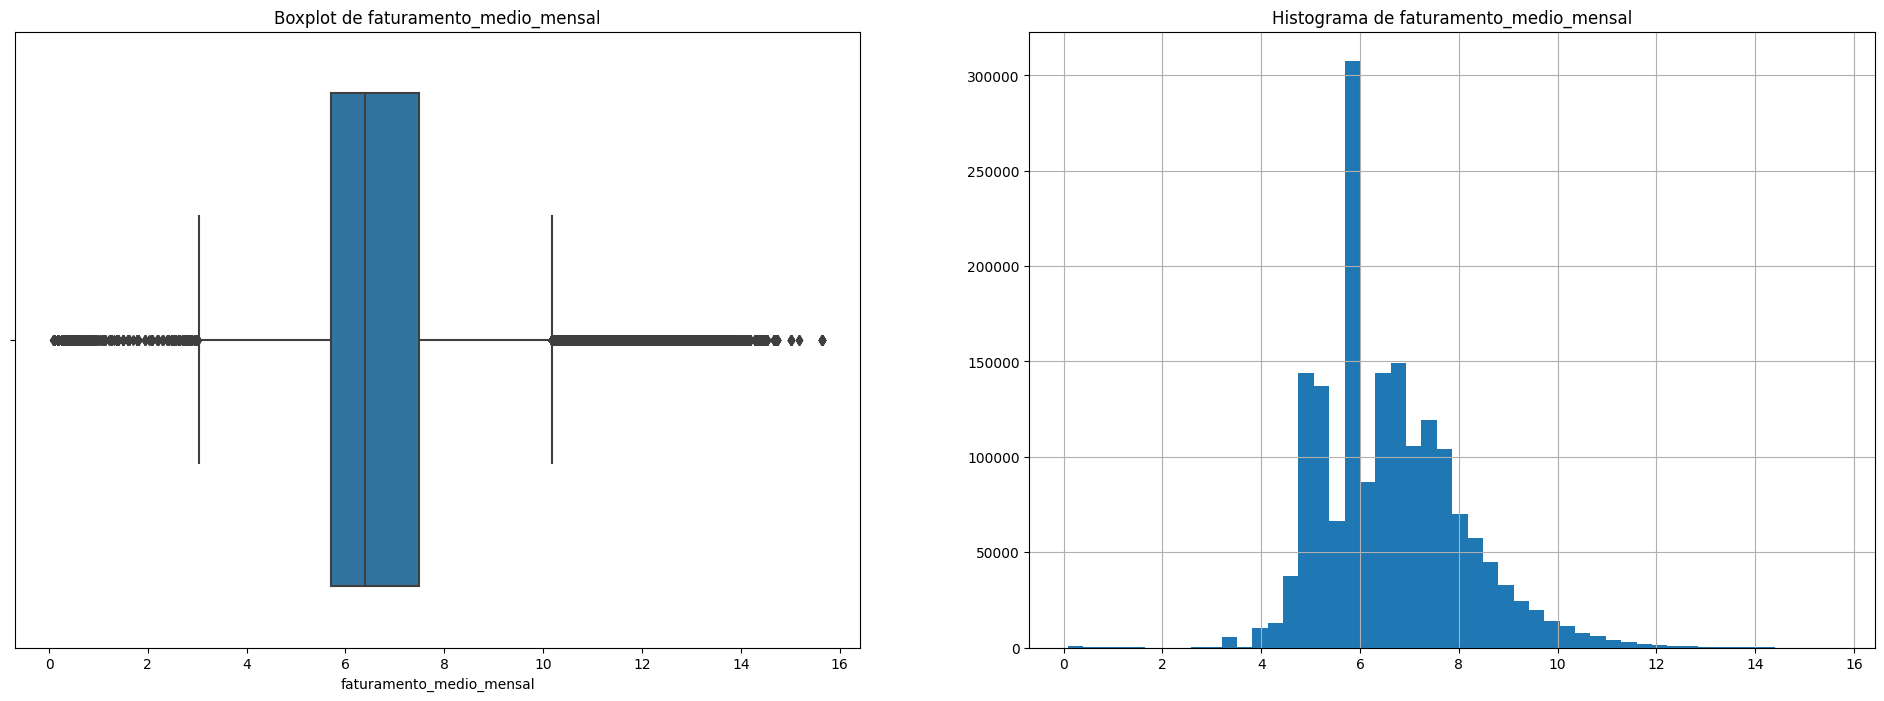

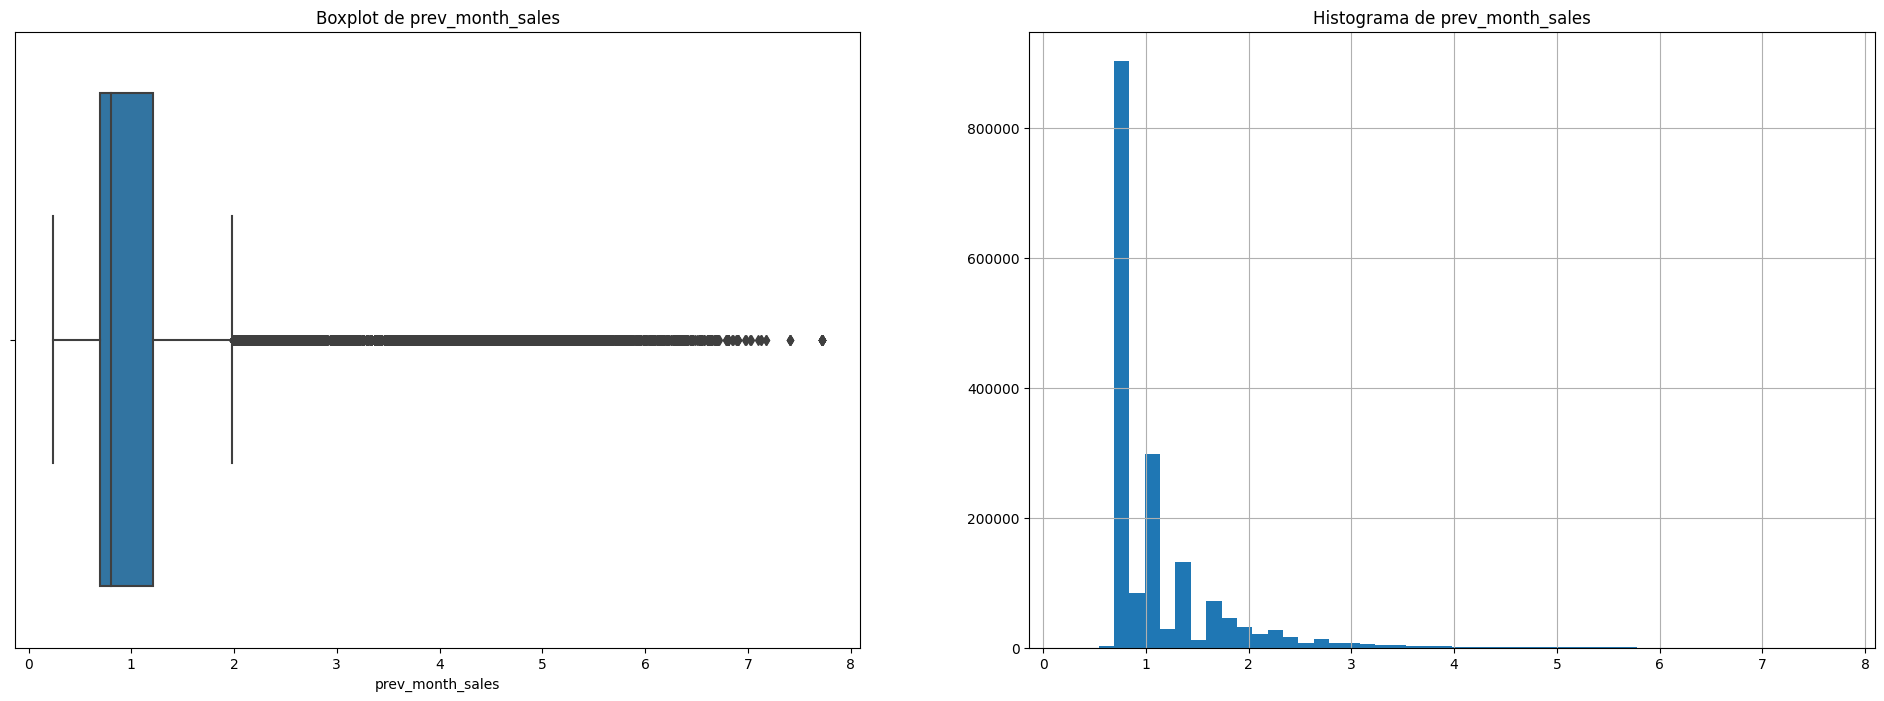

In [39]:
# Boxplot e histograma para 'item_price_mean'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['item_price_mean'])

plt.title('Boxplot de item_price_mean')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['item_price_mean'].hist(bins=50)

plt.title('Histograma de item_price_mean')



plt.show()



# Boxplot e histograma para 'item_cnt_day'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['item_cnt_day'])

plt.title('Boxplot de item_cnt_day')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['item_cnt_day'].hist(bins=50)

plt.title('Histograma de item_cnt_day')



plt.show()



# Boxplot e histograma para 'faturamento_medio_mensal'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['faturamento_medio_mensal'])

plt.title('Boxplot de faturamento_medio_mensal')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['faturamento_medio_mensal'].hist(bins=50)

plt.title('Histograma de faturamento_medio_mensal')



plt.show()





# Boxplot e histograma para 'prev_month_sales'

plt.figure(figsize=(24, 8))



# Boxplot

plt.subplot(1, 2, 1)

sns.boxplot(x=monthly_sales['prev_month_sales'])

plt.title('Boxplot de prev_month_sales')



# Histograma

plt.subplot(1, 2, 2)

monthly_sales['prev_month_sales'].hist(bins=50)

plt.title('Histograma de prev_month_sales')



plt.show()






In [40]:
monthly_sales.head()

,shop_id,date_block_num,item_id,mes_ano,year,month,item_cnt_day,item_price_mean,faturamento,faturamento_medio_mensal,...,shop_name,item_name,item_category_id,item_category_name,hist_min_item_price,hist_max_item_price,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,0,32,2013-01-01,2013,1,1.945910,5.402677,1326.0,7.190676,...,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD,70.62,349.0,6.0,6.0,6.0,0.0
1,0,0,33,2013-01-01,2013,1,1.386294,5.852202,1041.0,6.948897,...,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray,128.20,499.0,3.0,3.0,3.0,0.0
2,0,0,35,2013-01-01,2013,1,0.693147,5.513429,247.0,5.513429,...,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,40,Кино - DVD,148.00,399.0,1.0,1.0,1.0,0.0
3,0,0,43,2013-01-01,2013,1,0.693147,5.402677,221.0,5.402677,...,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,98.00,248.0,1.0,1.0,1.0,0.0
4,0,0,51,2013-01-01,2013,1,1.098612,4.863681,257.0,5.552960,...,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,101.50,299.0,2.0,2.0,2.0,0.0


In [41]:




# Verificar se há valores infinitos em cada coluna

infinite_values = monthly_sales.isin([np.inf, -np.inf]).sum()



# Verificar se há valores zero em cada coluna

zero_values = (monthly_sales == 0).sum()



# Filtrar e exibir as colunas com valores infinitos

columns_with_inf = infinite_values[infinite_values > 0]



# Exibir resultados

print("Colunas com valores infinitos:")

print(columns_with_inf)


Colunas com valores infinitos:
Series([], dtype: int64)


In [42]:
# Verificar se há valores NaN em cada coluna

monthly_sales = monthly_sales.dropna()

nan_values = monthly_sales.isna().sum()

print("Valores NaN por coluna:")

print(nan_values)

Valores NaN por coluna:
shop_id                     0
date_block_num              0
item_id                     0
mes_ano                     0
year                        0
month                       0
item_cnt_day                0
item_price_mean             0
faturamento                 0
faturamento_medio_mensal    0
item_price                  0
prev_month_sales            0
shop_name                   0
item_name                   0
item_category_id            0
item_category_name          0
hist_min_item_price         0
hist_max_item_price         0
item_cnt_min                0
item_cnt_max                0
item_cnt_mean               0
item_cnt_std                0
dtype: int64


## 4 - Aplicação do modelo

### Foram escolidos as variaveis mais relevantes que com menor correlação entre si para o modelo

In [43]:
# Codificando variáveis categóricas

le_item_name = LabelEncoder()

le_shop_name = LabelEncoder()

le_item_category_name = LabelEncoder()



monthly_sales['item_name_encoded'] = le_item_name.fit_transform(monthly_sales['item_name'])

monthly_sales['shop_name_encoded'] = le_shop_name.fit_transform(monthly_sales['shop_name'])





# 3. Criar a variável alvo (target) - previsão das vendas do próximo mês

df = monthly_sales.sort_values(by=['shop_name', 'item_name', 'mes_ano'])



# Criando a variável alvo (vendas no próximo mês)

df['target'] = df.groupby(['shop_name', 'item_name'])['item_cnt_day'].shift(-1)



# Remover as linhas com valores ausentes para o próximo mês (último mês de cada grupo)

df = df.dropna(subset=['item_cnt_day'])



# Definir variáveis independentes e dependentes

X = df[['month', 'item_price_mean', 'item_name_encoded', 'shop_name_encoded',"faturamento_medio_mensal",

        "item_price","prev_month_sales","hist_min_item_price","hist_max_item_price","item_cnt_min","item_cnt_max"]]



y = df['item_cnt_day']  # Agora, o alvo é a previsão das vendas do próximo mês, e não 'item_cnt_day'



# 6. Dividir os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)



# 7. Treinar o modelo XGBoost

# Convertendo os dados para o formato DMatrix que o XGBoost utiliza

train_data = xgb.DMatrix(X_train, label=y_train)

test_data = xgb.DMatrix(X_test, label=y_test)



# 7. Treinar o modelo XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir parâmetros do modelo XGBoost com regularização
params = {
    'objective': 'reg:squarederror',  # Regressão com erro quadrado
    'eval_metric': 'rmse',  # Usando RMSE como métrica
    'max_depth': 6,  # Profundidade máxima das árvores
    'learning_rate': 0.001,  # Taxa de aprendizado
    'colsample_bytree': 0.9,  # Fração de colunas a serem amostradas para cada árvore
    'subsample': 0.9,  # Fração de dados a serem amostrados para cada árvore
    'alpha': 0.1,  # Regularização L1 (Lasso)
    'lambda': 0.1  # Regularização L2 (Ridge)
}

# Treinamento com early stopping
watchlist = [(train_data, 'train'), (test_data, 'eval')]

model_xgb = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=1700,  # Número máximo de boosting rounds
    evals=watchlist,
    early_stopping_rounds=10  # Early stopping após 10 rodadas sem melhoria
)

# Garantir que o best_iteration está acessível
best_iteration = model_xgb.best_iteration if hasattr(model_xgb, 'best_iteration') else model_xgb.best_ntree_limit

# 8. Avaliar o modelo usando RMSE
# A partir da melhor iteração
y_pred_xgb = model_xgb.predict(test_data, iteration_range=(0, best_iteration))

# Calcular RMSE (Root Mean Squared Error)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular MAE (Mean Absolute Error)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Calcular R² (Coeficiente de Determinação)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Exibir os resultados
print(f'RMSE do modelo XGBoost: {rmse_xgb}')
print(f'MAE do modelo XGBoost: {mae_xgb}')
print(f'R² do modelo XGBoost: {r2_xgb}')


[0]	train-rmse:0.59551	eval-rmse:0.59633
[1]	train-rmse:0.59496	eval-rmse:0.59578
[2]	train-rmse:0.59443	eval-rmse:0.59524
[3]	train-rmse:0.59391	eval-rmse:0.59472
[4]	train-rmse:0.59337	eval-rmse:0.59418
[5]	train-rmse:0.59282	eval-rmse:0.59363
[6]	train-rmse:0.59230	eval-rmse:0.59312
[7]	train-rmse:0.59176	eval-rmse:0.59257
[8]	train-rmse:0.59124	eval-rmse:0.59206
[9]	train-rmse:0.59069	eval-rmse:0.59151
[10]	train-rmse:0.59015	eval-rmse:0.59097
[11]	train-rmse:0.58964	eval-rmse:0.59046
[12]	train-rmse:0.58910	eval-rmse:0.58992
[13]	train-rmse:0.58855	eval-rmse:0.58937
[14]	train-rmse:0.58801	eval-rmse:0.58883
[15]	train-rmse:0.58747	eval-rmse:0.58829
[16]	train-rmse:0.58693	eval-rmse:0.58775
[17]	train-rmse:0.58639	eval-rmse:0.58721
[18]	train-rmse:0.58585	eval-rmse:0.58667
[19]	train-rmse:0.58531	eval-rmse:0.58613
[20]	train-rmse:0.58477	eval-rmse:0.58559
[21]	train-rmse:0.58423	eval-rmse:0.58505
[22]	train-rmse:0.58369	eval-rmse:0.58452
[23]	train-rmse:0.58316	eval-rmse:0.58398
[2

### Conclusão:



#### O modelo `xgb.DMatrix` foi utilizado, pois os outros modelos apresentaram indícios de overfitting.





1. **RMSE (Root Mean Squared Error) = 0.18496**

   - O **RMSE** de 0.18496 é um valor moderado, indicando que, em média, a diferença entre as previsões do modelo e os valores reais é de aproximadamente 0.185 unidades. Embora não seja extremamente baixo, ainda sugere que o modelo está fazendo previsões relativamente precisas.



2. **MAE (Mean Absolute Error) = 0.11073**

   - O **MAE** de 0.11073 também é razoável, significando que, em média, o erro absoluto nas previsões do modelo é de 0.111 unidades. Embora não seja negligível, o valor sugere que o modelo está oferecendo previsões que estão relativamente próximas dos valores reais, mas há espaço para melhorias.



3. **R² (Coeficiente de Determinação) = 0.90397**

   - O **R²** de 0.90397 é muito bom, indicando que o modelo é capaz de explicar aproximadamente **90.4%** da variabilidade nos dados. Isso demonstra que o modelo está capturando a maior parte da estrutura dos dados e fazendo boas previsões, embora haja uma pequena parte da variabilidade que não está sendo explicada.



### Interpretação dos Resultados:



- **Precisão**: As previsões são bastante precisas, com erros moderados (RMSE e MAE), mas ainda há margem para otimizações.

- **Boa Generalização**: O **R²** sugere que o modelo está generalizando bem para os dados de teste, explicando a maior parte da variabilidade nos dados.

- **Desempenho Satisfatório**: Embora o modelo seja eficiente e consiga capturar uma boa parte da estrutura dos dados, há espaço para ajustes que possam reduzir ainda mais os erros. No geral, ele está apresentando um bom desempenho.


